In [114]:
import pandas as pd
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
import seaborn as sns
import pandas as pd
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch.nn as nn
import torch.optim as optim
import copy
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import intel_extension_for_pytorch as ipex
from sklearn.base import BaseEstimator,TransformerMixin

In [107]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)

xpu


In [108]:
path = os.path.abspath("") + '/../datasets/' 
# filename = 'capture-18-12-520k.pcapng'
filename = 'encrypted-23-12.pcapng'

## IpEncoder
Used to preprocess IP strings. Encodes 127.0.0.1 into 127 , 0, 0, 1. Used for __src_ip, dst_ip__ columns.
Output: DataFrame

In [109]:
# Split IP into 4 features
class IpEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            new_names = [column + '_' + str(i) for i in range(4)]
            splitted = X_tmp[column].str.split('.', expand = True).astype(int)
            splitted.columns = new_names
            cols.append(new_names)
    
            X_tmp = pd.concat([X_tmp, splitted], axis = 1)
        X_tmp.drop(columns = self.column_names, inplace = True)
        return X_tmp


## Explore data

First, lets plot netflow clusters distribution

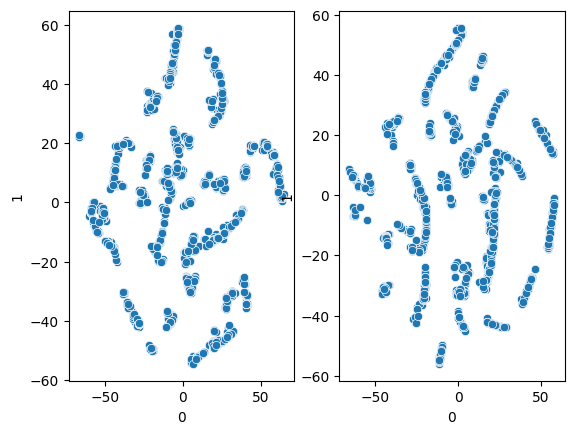

In [120]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_tsne(data, ax):
    pca = PCA(n_components=50)
    data_sampled = data.sample(2400) if len(data) > 2400 else data
    X_reduced = pca.fit_transform(data_sampled)
    tsne = TSNE(n_components=2)
    X_modified = tsne.fit_transform(X_reduced)
    df_modified = pd.DataFrame(X_modified)
    sns.scatterplot(x = df_modified[0], y = df_modified[1], ax = ax)

def preprocess(filename):
    streamer = NFStreamer(source=path+filename, statistical_analysis=True)
    ip_encoder = IpEncoder(['src_ip', 'dst_ip'])
    df = streamer.to_pandas()
    df = df[df['ip_version'] == 4].drop(columns = ['src_oui', 'ip_version', 'dst_oui', 'application_name', 'application_category_name', 'vlan_id', 'expiration_id', 'content_type', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'requested_server_name', 'src_mac', 'dst_mac', 'application_is_guessed', 'application_confidence', 'tunnel_id', 'id'])
    X_transformed = ip_encoder.fit_transform(df)
    return X_transformed



fig, ax =plt.subplots(1,2)
plot_tsne(preprocess('encrypted-23-12.pcapng'), ax=ax[0])
plot_tsne(preprocess('communication-plain-mysql.pcapng'), ax=ax[1])
fig.show()

Now we will plot a heatmap of payload bytes distribution

In [128]:
plain_flows_distro = get_distro('communication-plain-mysql.pcapng')
encr_flows_distro = get_distro('encrypted-23-12.pcapng')

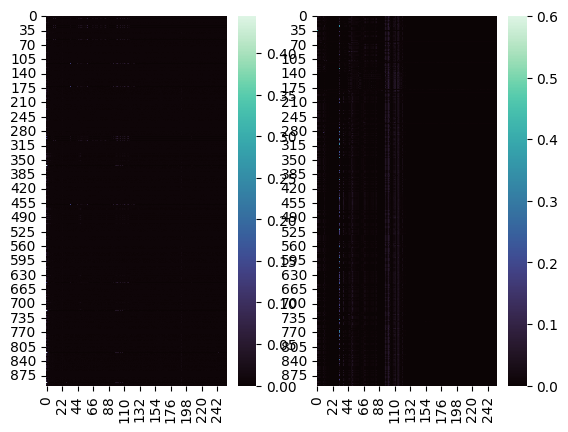

In [144]:
def get_distro(filename):
    streamer = NFStreamer(source=path+filename, udps=PayloadCollector())
    distro = []
    for flow in streamer:
        distro.append(flow.udps.payload_byte_distro)
    return np.array(distro)
def plot_distro(distro, ax):
    sns.heatmap(distro[100:1000], cmap="mako", cbar=True, ax = ax)

fig, ax = plt.subplots(1,2)
plot_distro(encr_flows_distro, ax=ax[0])
plot_distro(plain_flows_distro, ax=ax[1])
fig.show()

## NFPlugin to extract payload bytes distribution

In [146]:
import collections
bytes_distro = []
class PayloadCollector(NFPlugin):

    @staticmethod
    def _extend_flow_payload(packet, flow):
        if packet.payload_size > 0:
            payload = packet.ip_packet[-packet.payload_size:]
            byte_counter = collections.Counter(payload)
            flow.udps.payload_byte_distro += [byte_counter.get(byte, 0) for byte in range(256)]

    def on_init(self, packet, flow):
        flow.udps.payload_byte_distro = np.zeros(256)
        self._extend_flow_payload(packet, flow)

    def on_update(self, packet, flow):
        self._extend_flow_payload(packet, flow)
    def on_expire(self, flow):
        flow.udps.payload_byte_distro = flow.udps.payload_byte_distro/max(1, sum(flow.udps.payload_byte_distro))

## Metadata dataset class
Creates network flows and fits them into a pipeline to process. 
Output: tensor of shape __N of flows, 1, 74__

In [147]:
class FlowDataset(Dataset):
  def __init__(self, filename, transforms = None):
    self.streamer = NFStreamer(source = filename, statistical_analysis=True)
    self.flows = self.streamer.to_pandas()
    self.flows = self.flows[self.flows['ip_version'] == 4]
    self.flows = self.flows.drop(columns=['src_oui', 'ip_version', 'dst_oui', 'application_name', 'application_category_name', 'vlan_id', 'expiration_id', 'content_type', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'requested_server_name', 'src_mac', 'dst_mac', 'application_is_guessed', 'application_confidence', 'tunnel_id', 'id'])
    categorical_columns = ['src_ip_' + str(i) for i in range(4)]
    categorical_columns.extend(['dst_ip_' + str(i) for i in range(4)])
    categorical_columns.extend(['protocol', 'src_port', 'dst_port'])
    columns_to_scale = self.flows.columns[self.flows.columns.map(lambda x: x not in categorical_columns and x not in ['src_ip', 'dst_ip'])]
    ct = ColumnTransformer([
            ('scaler', StandardScaler(), columns_to_scale)
        ], remainder='passthrough')
    ip_encoder = IpEncoder(['src_ip', 'dst_ip'])
    pipeline = Pipeline(steps= [
        ('ip_encoder', IpEncoder(['src_ip', 'dst_ip'])),
        ('scaler', ct)
    ])
    self.transforms = transforms
    pipeline.fit(self.flows)
    self.flows = pipeline.transform(self.flows)
    self.flows = torch.tensor(self.flows).unsqueeze(1)

  def __getitem__(self, idx):
    return self.flows[idx]

  def __len__(self):
    return len(self.flows)


## Payload dataset class
Using PayloadCollector plugin, payload bytes distribution is extracted for each flow and converted to a dataframe
Output: tensor of shape __N of flows, 1, 256__

In [148]:
class PayloadDataset(Dataset):
  def __init__(self, filename, transforms = None):
    self.streamer = NFStreamer(source = filename, udps = PayloadCollector())
    self.distro = []
    for flow in self.streamer:
        if flow.ip_version == 4:
            self.distro.append(flow.udps.payload_byte_distro)
    self.distro = torch.tensor(self.distro).unsqueeze(1)

  def __getitem__(self, idx):
    return self.distro[idx]

  def __len__(self):
    return len(self.distro)


In [149]:
metadata_df = FlowDataset(path + filename)
distro_df = PayloadDataset(path + filename)
torch.set_printoptions(sci_mode=False)
distro_df[0]

tensor([[0.0357, 0.0064, 0.0053, 0.0129, 0.0054, 0.0043, 0.0035, 0.0040, 0.0043,
         0.0035, 0.0043, 0.0039, 0.0035, 0.0037, 0.0046, 0.0049, 0.0030, 0.0052,
         0.0029, 0.0038, 0.0035, 0.0032, 0.0047, 0.0064, 0.0036, 0.0044, 0.0030,
         0.0051, 0.0039, 0.0037, 0.0035, 0.0036, 0.0035, 0.0025, 0.0030, 0.0052,
         0.0044, 0.0025, 0.0036, 0.0045, 0.0035, 0.0030, 0.0038, 0.0033, 0.0040,
         0.0039, 0.0032, 0.0029, 0.0044, 0.0038, 0.0039, 0.0037, 0.0043, 0.0032,
         0.0043, 0.0043, 0.0045, 0.0047, 0.0039, 0.0038, 0.0039, 0.0039, 0.0044,
         0.0033, 0.0023, 0.0043, 0.0040, 0.0033, 0.0037, 0.0051, 0.0028, 0.0035,
         0.0041, 0.0025, 0.0035, 0.0039, 0.0031, 0.0039, 0.0047, 0.0037, 0.0036,
         0.0015, 0.0028, 0.0046, 0.0029, 0.0043, 0.0039, 0.0040, 0.0035, 0.0039,
         0.0035, 0.0040, 0.0028, 0.0032, 0.0038, 0.0039, 0.0026, 0.0043, 0.0044,
         0.0043, 0.0024, 0.0040, 0.0031, 0.0031, 0.0044, 0.0035, 0.0045, 0.0054,
         0.0041, 0.0029, 0.0

In [97]:
dataloader = DataLoader(distro_df, batch_size=5, shuffle=True)

## LSTM based autoencoder
The Autoencoder has 2 LSTM layers and 2 Linear layers dividing them

In [150]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMAutoencoder, self).__init__()

        self.lstm_encoder1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.lstm_encoder2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc_encoder = nn.Linear(hidden_dim, latent_dim)  # Fully connected to map to latent space

        self.fc_decoder = nn.Linear(latent_dim, hidden_dim)  # Fully connected to expand to hidden_dim
        self.lstm_decoder1 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.lstm_decoder2 = nn.LSTM(input_size=hidden_dim, hidden_size=input_dim, batch_first=True)  # Reconstruct to input_dim

    def forward(self, x):
        # Encoder part
        _, (h_n1, _) = self.lstm_encoder1(x)  # First encoder LSTM
        _, (h_n2, _) = self.lstm_encoder2(h_n1[-1].unsqueeze(0))  # Second encoder LSTM

        latent_code = self.fc_encoder(h_n2[-1])  # Map to latent space (latent_dim)

        # Decoder part
        latent_code = self.fc_decoder(latent_code).unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat to sequence length
        decoded, _ = self.lstm_decoder1(latent_code)  # First decoder LSTM
        decoded, _ = self.lstm_decoder2(decoded)  # Second decoder LSTM

        return decoded

# Parameters
input_dim = 256  # Number of features
hidden_dim = 64  # Hidden layer dimension (can be adjusted)
latent_dim = 32  # Latent dimension size (can be adjusted)
sequence_length = 1 

# Create model
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim)
model = model.to(device)

In [ ]:
epochs = 50
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss(reduction='sum').to(device)


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        batch = batch.float()
        inputs = batch.to(device) 
        labels = batch.to(device)
        # print(inputs.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # MSE between input and reconstructed output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}')